# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/CheloGE/ML-tensorflow-Image_classifier-oxford_flowers102/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [0]:
# TODO: Make all necessary imports.
import numpy as np
import pandas as pd
import cv2
import requests
import json
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip --no-cache-dir install tfds-nightly

     |████████████████████████████████| 3.3MB 4.8MB/s 
  Found existing installation: tensorflow-metadata 0.21.2
    Uninstalling tensorflow-metadata-0.21.2:
      Successfully uninstalled tensorflow-metadata-0.21.2


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [3]:
# Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incompleteD8PB3P/oxford_flowers102-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incompleteD8PB3P/oxford_flowers102-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incompleteD8PB3P/oxford_flowers102-validation.tfrecord



Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.0.0. Subsequent calls will reuse this data.


In [16]:
# Print out dataset info
print(f"Number of training data points: {dataset_info.splits['train'].num_examples}")
print(f"Number of testing data points: {dataset_info.splits['test'].num_examples}")
print(f"Number of validation data points: {dataset_info.splits['validation'].num_examples}")

Number of training data points: 1020
Number of testing data points: 6149
Number of validation data points: 1020


In [20]:
# print shapes of 3 firs images
for feature, label in dataset['train'].take(3):
    print(feature.shape)

(500, 667, 3)
(500, 666, 3)
(670, 500, 3)


In [0]:
dataset_np = tfds.as_numpy(dataset)
train_data = pd.DataFrame(list(dataset_np['train']), columns=['features', 'labels']) 
validation_data = pd.DataFrame(list(dataset_np['validation']), columns=['features', 'labels']) 
test_data = pd.DataFrame(list(dataset_np['test']), columns=['features', 'labels']) 

In [0]:
# Dividing data into features and labels
X_train = train_data['features']
Y_train = train_data['labels']
X_validation = validation_data['features']
Y_validation = validation_data['labels']
X_test = test_data['features']
Y_test = test_data['labels']

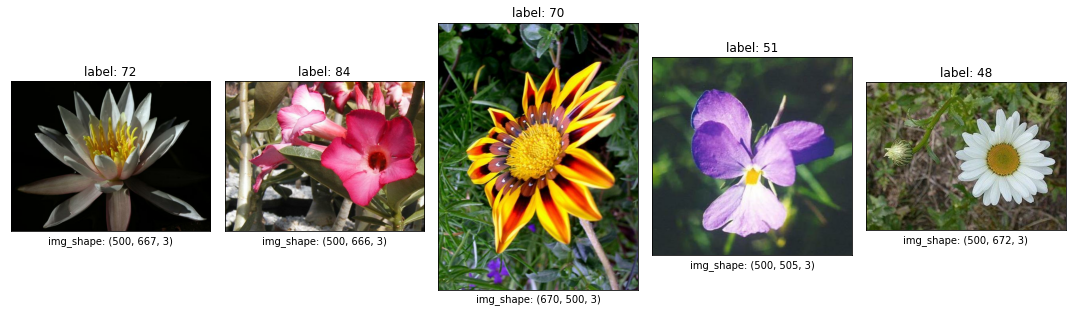

In [0]:
# Visualizing data
fig = plt.figure(figsize=(15,15))
i=0
for image, label in zip(X_train.head(),Y_train.head()):
    ax = fig.add_subplot(1,5,i+1)
    ax.set_xticks([])
    ax.set_yticks([]) 
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.xlabel(f"img_shape: {image.shape}")
    i=i+1;
fig.tight_layout()

As we can see above, images are not of same shape. Therefore, we will proceed to resize and normalize images. All functions for achieving this are below:

In [0]:
def resize_image(images, size=(224,224)):
    """
      This functions gets a bunch of images and resize them to the input size
      @params size: desired size of the images
      @params images: group of images to resize

      @return resized_images: a numpy array with all new resized images
    """
    height = size[0]
    width = size[1]
    resized_images = []
    for image in images:
      resized_images.append(cv2.resize(image, (height, width)))
    return np.array(resized_images)

In [0]:
def normalize_image(images, a=-1, b=1, initial_range=[0,255]):
    """
    Normalize the image data with Min-Max scaling to a range of [a, b] 
    @params images: The images data to be normalized
    @return: Normalized image data
    """
    min_pixel = np.array(initial_range[0])
    max_pixel = np.array(initial_range[1])
    return a + (((images - min_pixel)*(b - a) )/(max_pixel - min_pixel))

In [0]:
def oneHotEncode(labels):
    """
    One hot encode Ordinal labels
    @params labels: bunch of labels we want to hot encode
    @return one hot encoded labels
    """
    oneHotEncode = LabelBinarizer()
    oneHotEncode.fit(labels)
    return oneHotEncode.transform(labels)

In [0]:
## Format images: 
# resize images & normalize images
X_train = normalize_image(resize_image(X_train))
X_test = normalize_image(resize_image(X_test))
X_validation = normalize_image(resize_image(X_validation))

In [0]:
## One hot encode labels
Y_train_oneHot = oneHotEncode(Y_train)
Y_test_oneHot = oneHotEncode(Y_test)
Y_validation_oneHot = oneHotEncode(Y_validation)

## Explore the Dataset

In [31]:
print(f"Training - X shape: {X_train.shape}, Y shape: {Y_train_oneHot.shape}")
print(f"Testing - X shape: {X_test.shape}, Y shape: {Y_test_oneHot.shape}")
print(f"Validation - X shape: {X_validation.shape}, Y shape: {Y_validation_oneHot.shape}")
print(f"number of classes: {Y_train_oneHot.shape[1]}")

Training - X shape: (1020, 224, 224, 3), Y shape: (1020, 102)
Testing - X shape: (6149, 224, 224, 3), Y shape: (6149, 102)
Validation - X shape: (1020, 224, 224, 3), Y shape: (1020, 102)
number of classes: 102


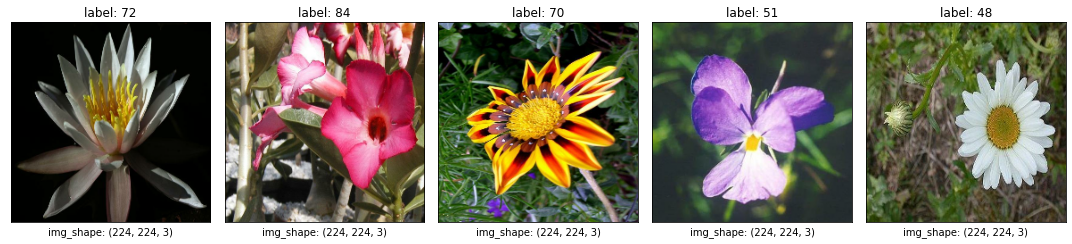

In [36]:
# Visualizing first 5 training images
fig = plt.figure(figsize=(15,15))
i=0
for image, label in zip(X_train[:5], Y_train[:5]):
    ax = fig.add_subplot(1,5,i+1)
    ax.set_xticks([])
    ax.set_yticks([]) 
    plt.imshow(normalize_image(image, a=0, b=1, initial_range=[-1,1]))
    plt.title(f"label: {label}")
    plt.xlabel(f"img_shape: {image.shape}")
    i=i+1;
fig.tight_layout()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [0]:
file_location='https://github.com/CheloGE/ML-tensorflow-Image_classifier-oxford_flowers102/blob/master/label_map.json?raw=1'
r = requests.get(file_location, stream=True)
class_names=json.loads(r.content.decode('utf-8'))
class_names = {int(k):v for k,v in class_names.items()}

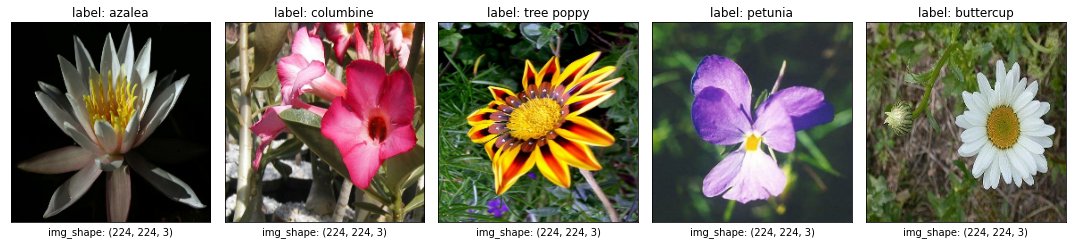

In [39]:
# Visualizing first 5 training images
fig = plt.figure(figsize=(15,15))
i=0
for image, label in zip(X_train[:5], Y_train[:5]):
    ax = fig.add_subplot(1,5,i+1)
    ax.set_xticks([])
    ax.set_yticks([]) 
    plt.imshow(normalize_image(image, a=0, b=1, initial_range=[-1,1]))
    plt.title(f"label: {class_names[label]}")
    plt.xlabel(f"img_shape: {image.shape}")
    i=i+1;
fig.tight_layout()

## Create Pipeline

In [0]:
# Create a pipeline for an image
def preprocess_image(image):
    """
        Pipeline to preprocess a new image or set of images
    """
    return normalize_image(resize_image(image, size=(224,224)))


In [0]:
# Create a pipeline for each set based on batch
def get_batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    
    assert len(features) == len(labels)
    # shuffle the data
    X, Y = shuffle(features, labels)
    # TODO: Implement batching
    output_batches = []
    
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [X[start_i:end_i], Y[start_i:end_i]]
        output_batches.append(batch)
        
    return np.array(output_batches)


In [71]:
# Sanity check
get_batches(128, X_train, Y_train_oneHot).shape

(8, 2)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [0]:
from tensorflow.keras import Sequential
import tensorflow_hub as hub 
# Build and train your network.
#module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/2")
#Sequential()
Model_path = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
myModel = Sequential()
myModel.add(hub.KerasLayer(Model_path))


In [29]:
myModel.build([None, 224, 224, 3])
myModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   multiple                  3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [0]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.



## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [0]:
# TODO: Print the loss and accuracy values achieved on the entire test set.



## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [0]:
# TODO: Save your trained model as a Keras model.



## Load the Keras Model

Load the Keras model you saved above.

In [0]:
# TODO: Load the Keras model



# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [0]:
# TODO: Create the process_image function



To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

In [0]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [0]:
# TODO: Create the predict function



# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='https://github.com/CheloGE/ML-tensorflow-Image_classifier-oxford_flowers102/blob/master/assets/inference_example.png?raw=1' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [0]:
# TODO: Plot the input image along with the top 5 classes
